# Códigos proyecto Simulación Estocástica

Integrantes:

 - Francine Palacios
 - Alejandro Villazón

## Generación de código

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from scipy.special import gamma
import timeit

import warnings
warnings.filterwarnings("ignore")

In [2]:
class SpatialFieldSimulator:
    def __init__(self, sqrt_n, initial_method='CHOL'):
        self.sqrt_n = sqrt_n
        self.initial_method = initial_method
        self.grid = self.generate_regular_grid(sqrt_n)
        if self.initial_method == 'TB':
          self.distances_matrix = None
        else:
          self.distances_matrix = distance_matrix(self.grid, self.grid)
        self.method = None
        self.model = None

    def simulate(self, method='turning_bands', **args):
        """
        Simula campos aleatorios espaciales gaussianos isotrópicos utilizando diferentes métodos.

        Args:
            method (str): El método a utilizar ('cholesky' o 'turning_bands').
            **args: Argumentos adicionales específicos para cada método.

        Returns:
            numpy.ndarray: Un array que contiene la simulación del campo aleatorio espacial.

        Raises:
            ValueError: Si el método no es válido.

        Esta función permite simular campos aleatorios espaciales utilizando diferentes métodos,
        como Cholesky o Turning Bands.
        """
        if method not in ['cholesky', 'turning_bands']:
            raise ValueError("Método no válido. Los métodos permitidos son: ['cholesky', 'turning_bands']")

        self.method = method

        if method == 'cholesky':
            return self.cholesky(**args)
        else:
            return self.turning_bands(**args)

    def cholesky(self, model='exponential', **args):
        """
        Simula campos aleatorios espaciales utilizando el método de la
        descomposición de Cholesky con un modelo de covarianza isotrópico específico.

        Args:
            model (str): El modelo de covarianza a utilizar.
            **args: Argumentos adicionales específicos para el modelo de covarianza.

        Returns:
            numpy.ndarray: Un array que contiene la simulación del campo aleatorio espacial.

        Raises:
            ValueError: Si el modelo de covarianza no es válido.

        Modelos de covarianza permitidos:
        - 'exponential': Modelo exponencial de covarianza.
        - 'powered_exponential': Modelo exponencial potencia de covarianza.
        - 'spheric': Modelo esférico de covarianza.
        - 'askey': Modelo de covarianza Askey.
        - 'matern': Modelo de covarianza Matérn.

        Ejemplo de uso:
        ```
        model = 'exponential'
        args = {'alpha': 0.5}
        simulated_field = spatial_simulator.cholesky(model, **args)
        ```
        """
        models = {
            'exponential': self.exponential,
            'powered_exponential': self.powered_exponential,
            'spheric': self.spheric,
            'askey': self.askey,
            'matern': self.matern
        }

        if model not in models:
            raise ValueError(f"Modelo de covarianza no válido. Los modelos permitidos son: {list(models.keys())}")
        self.model = model

        cov = models[model](**args)
        cholesky_matrix = np.linalg.cholesky(cov(self.distances_matrix))
        random_samples = np.random.normal(0, 1, self.sqrt_n**2)

        return cholesky_matrix @ random_samples
    @staticmethod
    def telis(alpha, **args):
        """
        Calcula la densidad espectral del modelo de covarianza Telis.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.

        Returns:
            function: Una función que calcula la densidad espectral para un punto x del espacio.

        Raises:
            ValueError: Si el parámetro alpha no cumple con la restricción alpha > 0.

        f(x) = 4(||x||/alpha)^2 / (pi * alpha * (1+(||x||/alpha)**2)**2)
        """
        return lambda x : 4*(np.linalg.norm(x)/alpha)**2/(np.pi * alpha * (1 + (np.linalg.norm(x)/alpha)**2)**2)

    def matern(self, alpha, nu, **args):
        """
        Si el método de simulación es 'cholesky' genera una función de covarianza Matern,
        si es 'turning_bands' genera la densidad espectral.

        Args:
            alpha (float): Parámetro de escala que controla el alcance espacial de la covarianza.
            nu (float): Parámetro de suavidad que determina la rugosidad de la covarianza. Debe ser positivo.
        **args:
            Otros argumentos opcionales.

        Returns:
            function: Función de covarianza o densidad espectral dependiendo del método de simulación.

        Raises:
            ValueError: Si el método es 'cholesky' y nu no es igual a 1.5.

        """
        if self.method == 'cholesky':
          if nu != 1.5:
            raise ValueError('El método Cholesky con modelo Mátern solo acepta nu=3/2.')
          else:
            return lambda h : (1 + h/alpha) * np.exp(-h/alpha) # nu=3/2
        else:
            return lambda x : (gamma(nu+1)*alpha**(-2*nu))/(np.pi*gamma(nu))*(alpha**(-2)+np.dot(x,x))**(-nu-1)

    def simulate_one_turning_band(self, **args):
        """
        Simula una única banda de giro para campos aleatorios espaciales. Usando Importance Sampling con
        densidad instrumental una normal bivariada estándar.

        **args:
            Argumentos opcionales que pueden ser específicos para ciertos modelos de simulación.

        Returns:
            numpy.ndarray: Un array que contiene la simulación de una banda de giro.

        Esta función simula una única banda de giro para campos aleatorios espaciales.
        Utiliza un modelo de covarianza específico, por ejemplo el modelo Matérn.
        """
        g = lambda x: (1/(2*np.pi)) * np.exp(-np.dot(x,x)/2)
        u = np.random.normal(0, 1, 2)
        phi = np.random.uniform(0, 2*np.pi, 1)
        if self.model == 'matern':
            f = self.matern(**args)
        if self.model == 'telis':
            f = self.telis(**args)
        return np.sqrt(2*f(u)/g(u))*np.cos(np.dot(self.grid, u) + phi)

    def turning_bands(self, L=1_000, model='matern', **args):
        """
        Simula campos aleatorios espaciales utilizando el método de bandas de giro.
        Utilizando `L` veces la función `simulate_one_turning_band()`.

        Args:
            L (int): Número de bandas de giro a simular.
            model (str): Modelo de covarianza a utilizar para la simulación.
            **args: Argumentos opcionales específicos del modelo de covarianza.

        Returns:
            numpy.ndarray: Un array que contiene la simulación del campo aleatorio espacial.

        Raises:
            ValueError: Si el modelo de covarianza no es válido.

        Modelos de covarianza permitidos:
        - 'matern': Modelo de covarianza Matérn.
        - 'telis': Modelo de covarianza Telis.

        Ejemplo de uso:
        ```python
        # Simular campos aleatorios espaciales con el método de bandas de giro y modelo Matern
        params = {
            'alpha' : 15,
            'nu' : 1.5,
        }
        field_simulation = spatial_simulator.turning_bands(L=1_000, model='matern', **params)
        ```
        """
        models = ['matern', 'telis']
        if model not in models:
            raise ValueError(f"Modelo de covarianza no válido. Los modelos permitidos son: {models}")
        self.model = model

        Z = self.simulate_one_turning_band(**args)
        for i in range(L-1):
            Z += self.simulate_one_turning_band(**args)
        return Z / np.sqrt(L)

    def variogram(self, values, h_max=None, n_lags=None):
        """
        Calcula el variograma a partir de un vector unidimensional de valores.

        Args:
            values (numpy.ndarray): Vector unidimensional de valores a partir de los cuales se calcula el variograma.
            h_max (float): Máxima distancia de lag a considerar en el variograma.
            n_lags (int, optional): Número de lags en los que se divide el rango de distancia. Valor predeterminado es 10.

        Returns:
            numpy.ndarray: Un array de lags (distancias) y semivariogramas calculados.

        Esta función calcula el variograma a partir de un vector de valores y devuelve los lags y los semivariogramas calculados.
        """
        if self.initial_method == 'TB':
            self.distances_matrix = distance_matrix(self.grid, self.grid)
        if h_max == None:
            h_max = self.distances_matrix.max()/3
        if n_lags == None:
            n_lags = int(np.ceil(2 * np.log2(self.sqrt_n) + 1))

        lags, step = np.linspace(0, h_max, n_lags, retstep=True)
        semivariograms = np.zeros(n_lags)

        for i in range(n_lags):
            lag = lags[i]
            lag_lower_bound = lag - step/2
            lag_upper_bound = lag + step/2

            lag_indices = np.where((self.distances_matrix > lag_lower_bound) & (self.distances_matrix <= lag_upper_bound))

            if lag_indices[0].size > 0:
                valid_pairs = values[lag_indices[0]] - values[lag_indices[1]]
                semivariograms[i] = 0.5 * np.mean(valid_pairs ** 2)

        return lags, semivariograms

    @staticmethod
    def generate_regular_grid(sqrt_n):
        """
        Genera una cuadrícula de puntos regularmente espaciados en un cuadrado.

        Args:
            sqrt_n (int): El número de puntos a lo largo de cada dimensión.

        Returns:
            numpy.ndarray: Un array 2D que contiene los puntos de la cuadrícula.

        Raises:
            ValueError: Si sqrt_n no es un entero positivo.

        La función genera sqrt_n^2 puntos regularmente espaciados en el cuadrado [1, sqrt_n] x [1, sqrt_n].
        Los puntos están ordenados de izquierda a derecha y de abajo hacia arriba.
        """

        if not isinstance(sqrt_n, int) or sqrt_n <= 0:
            raise ValueError("sqrt_n debe ser un entero positivo")

        xx = np.linspace(1, sqrt_n, sqrt_n)
        X, Y = np.meshgrid(xx, xx)
        return np.column_stack((X.flatten(), Y.flatten()))

    @staticmethod
    def exponential(alpha, **args):
        """
        Calcula la covarianza del modelo exponencial, caso particular del modelo exponencial potencia con beta=1.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.

        Returns:
            function: Una función que calcula la covarianza para una distancia h.

        Raises:
            ValueError: Si el parámetro alpha no cumple con la restricción alpha > 0.

        Cov(h) = exp(-||h|| / alpha)
        """

        if alpha <= 0:
            raise ValueError("El parámetro alpha debe ser mayor que 0")

        return lambda h: np.exp(-h/alpha)

    @staticmethod
    def powered_exponential(alpha, beta, **args):
        """
        Calcula la covarianza del modelo exponencial potencia.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.
            beta (float): Parámetro beta, donde 0 < beta <= 2.

        Returns:
            function: Una función que calcula la covarianza para una distancia h.

        Raises:
            ValueError: Si los parámetros no cumplen con las restricciones.

        Cov(h) = exp(-||h||^beta / alpha)
        """

        if alpha <= 0 or beta <= 0 or beta > 2:
            raise ValueError("Los parámetros alpha y beta deben cumplir con las restricciones: alpha > 0 y 0 < beta <= 2")

        return lambda h: np.exp(-h**beta/alpha)

    @staticmethod
    def spheric(alpha, **args):
        """
        Calcula la covarianza del modelo esférico.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.

        Returns:
            function: Una función que calcula la covarianza para una distancia h.

        Raises:
            ValueError: Si el parámetro alpha no cumple con la restricción alpha > 0.

        Cov(h) = (1 + ||h|| / (2 * alpha)) * max(1 - ||h|| / alpha, 0)^2
        """

        if alpha <= 0:
            raise ValueError("El parámetro alpha debe ser mayor que 0")

        return lambda h: (1+h/(2*alpha)) * np.maximum(1-h/alpha, 0)**2

    @staticmethod
    def askey(alpha, nu, **args):
        """
        Calcula la covarianza del modelo Askey.

        Args:
            alpha (float): Parámetro alpha, donde alpha > 0.
            nu (float): Parámetro nu, donde nu >= (d+1)/2 = 1

        Returns:
            function: Una función que calcula la covarianza para una distancia h.

        Raises:
            ValueError: Si los parámetros no cumplen con las restricciones.

        Cov(h) = max(1 - ||h|| / alpha, 0)^nu
        """

        if alpha <= 0 or nu<1:
            raise ValueError("Los parámetros alpha y nu deben cumplir con las restricciones: alpha > 0 y nu >= 1")

        return lambda h: np.maximum(1- h/alpha, 0)**nu

## Gráficos de interés

### Ejemplo grilla regular

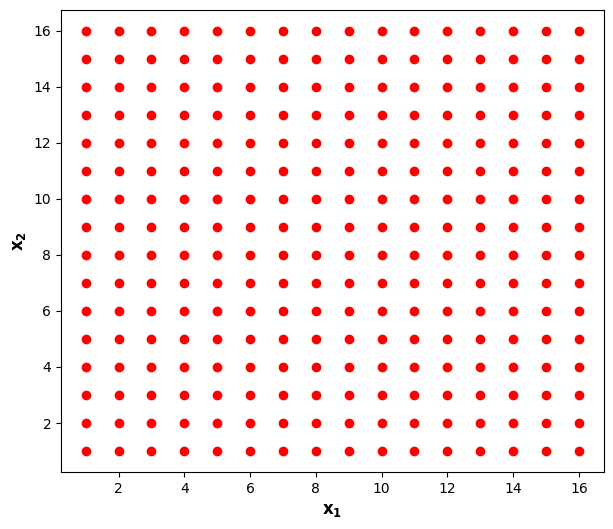

In [3]:
points = SpatialFieldSimulator.generate_regular_grid(16)

plt.figure(figsize=(7,6))
plt.scatter(points[:,0], points[:,1], color='r', marker='o')
plt.xlabel(r'$\mathbf{x_1}$', fontsize=12)
plt.ylabel(r'$\mathbf{x_2}$', fontsize=12)
plt.show()

## Verificación de resultados


### Método de Cholesky

In [4]:
params = {
    'model' : 'spheric',
    'method': 'cholesky',
    'alpha' : 15,
}

In [5]:
%%time
simulator = SpatialFieldSimulator(50)

CPU times: user 339 ms, sys: 14.8 ms, total: 354 ms
Wall time: 357 ms


In [6]:
%%time
points = simulator.simulate(**params)

CPU times: user 357 ms, sys: 156 ms, total: 513 ms
Wall time: 481 ms


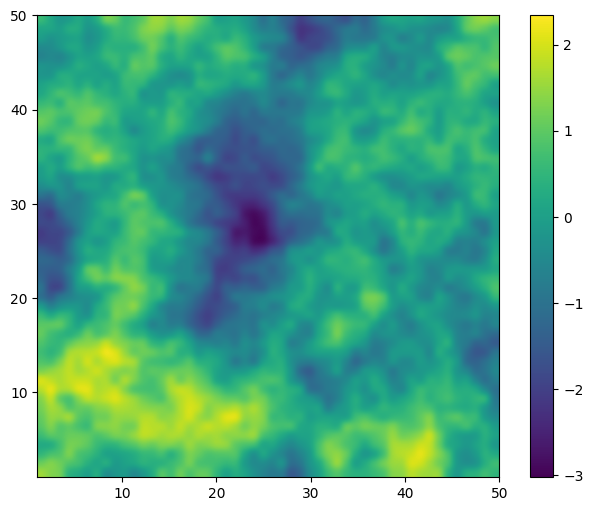

In [7]:
plt.figure(figsize=(8,6))
plt.imshow(points.reshape((simulator.sqrt_n, simulator.sqrt_n)),
           extent = [1,simulator.sqrt_n,1,simulator.sqrt_n],
           interpolation = 'gaussian'
           )
plt.colorbar(); plt.show()

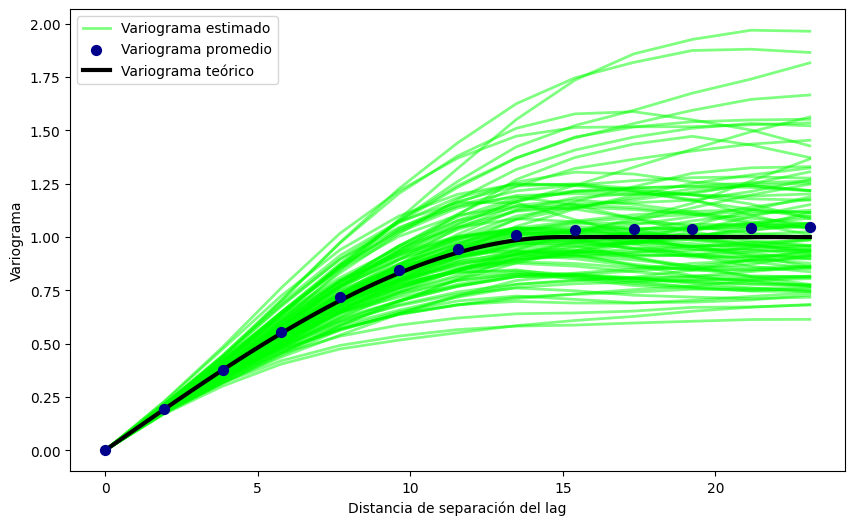

In [8]:
n_simulates = 100

plt.figure(figsize=(10,6))
points = simulator.simulate(**params)
hs, suma = simulator.variogram(points)
plt.plot(hs, suma, c='lime', lw=2, alpha=0.5, label='Variograma estimado')

for _ in range(n_simulates-1):
    points = simulator.simulate(**params)
    lags, semivariograms = simulator.variogram(points)
    suma += semivariograms
    plt.plot(lags, semivariograms, c='lime', lw=2, alpha=0.5)

plt.scatter(hs, suma/n_simulates, s=50, c='darkblue',
            zorder=3, label='Variograma promedio')

cov = simulator.spheric(**params)
x = np.linspace(0, hs.max(), 100)
plt.plot(x, cov(0)-cov(x), lw=3, label='Variograma teórico', c='k', zorder=2)
plt.ylabel('Variograma')
plt.xlabel('Distancia de separación del lag')
plt.legend();

### Método Turning Bands

In [9]:
params = {
    'model' : 'matern',
    'method': 'turning_bands',
    'alpha' : 2.5,
    'nu' : 1.5,
    'L' : 1_000
}

In [10]:
%%time
simulator = SpatialFieldSimulator(50)

CPU times: user 309 ms, sys: 16.2 ms, total: 325 ms
Wall time: 333 ms


In [11]:
%%time
points = simulator.simulate(**params)

CPU times: user 43.1 ms, sys: 810 µs, total: 43.9 ms
Wall time: 44.9 ms


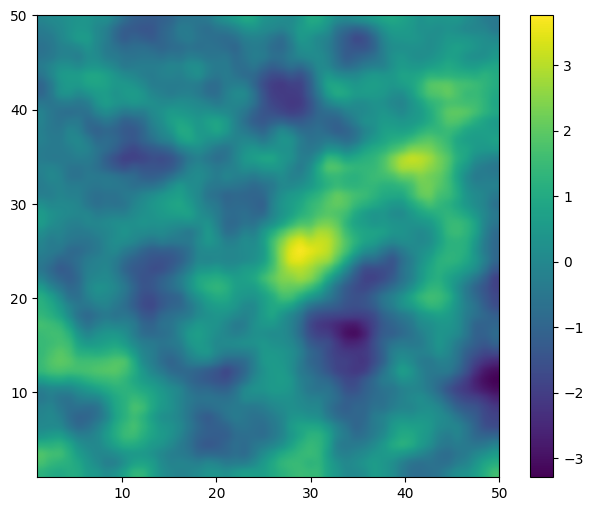

In [12]:
plt.figure(figsize=(8,6))
plt.imshow(points.reshape((simulator.sqrt_n, simulator.sqrt_n)),
           extent = [1,simulator.sqrt_n,1,simulator.sqrt_n],
           interpolation = 'gaussian'
           )
plt.colorbar(); plt.show()

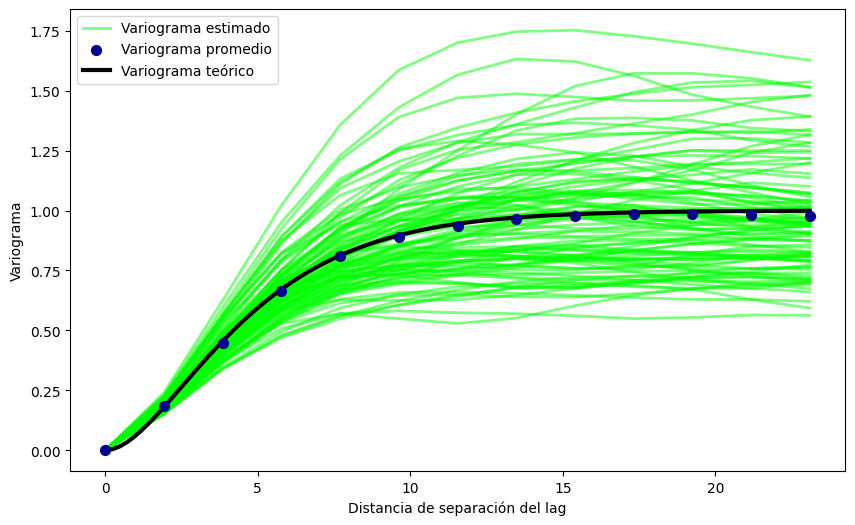

In [13]:
n_simulates = 100

plt.figure(figsize=(10,6))
points = simulator.simulate(**params)
hs, suma = simulator.variogram(points)
plt.plot(hs, suma, c='lime', lw=2, alpha=0.5, label='Variograma estimado')

for _ in range(n_simulates-1):
    points = simulator.simulate(**params)
    lags, semivariograms = simulator.variogram(points)
    suma += semivariograms
    plt.plot(lags, semivariograms, c='lime', lw=2, alpha=0.5)

plt.scatter(hs, suma/n_simulates, s=50, c='darkblue',
            zorder=3, label='Variograma promedio')

simulator.method='cholesky'
cov = simulator.matern(alpha=params['alpha'], nu=params['nu'])
x = np.linspace(0, hs.max(), 100)
plt.plot(x, cov(0)-cov(x), lw=3, label='Variograma teórico', c='k', zorder=2)
plt.ylabel('Variograma')
plt.xlabel('Distancia de separación del lag')
plt.legend();

## Contraste de tiempos

Se compara los tiempos de simulación entre ambos metodos, variando el tamaño de la malla $n$. Para esto se fijara el modelo de 'matern' con parametros de suavidad $\nu= 1.5$ y rango practico $\alpha = \sqrt n/20$.

Para el modelo de Turning Bands se usara un $L=1000$ bandas.  

In [14]:
params_chol = {
    'model' : 'matern',
    'method': 'cholesky',
    'nu' : 1.5,
}
params_tb = {
    'model' : 'matern',
    'method': 'turning_bands',
    'nu' : 1.5,
    'L' : 1_000
}

In [15]:
repeat = 25
sqrtns = range(2, 150, 15)

In [16]:
%%time
times_chol = [timeit.timeit(lambda: SpatialFieldSimulator(sqrtn).simulate(alpha=sqrtn/20, **params_chol), number=repeat) for sqrtn in sqrtns]
times_tb = [timeit.timeit(lambda: SpatialFieldSimulator(sqrtn, 'TB').simulate(alpha=sqrtn/20, **params_tb), number=repeat) for sqrtn in sqrtns]

CPU times: user 1h 35min 40s, sys: 7min 22s, total: 1h 43min 3s
Wall time: 1h 16min 2s


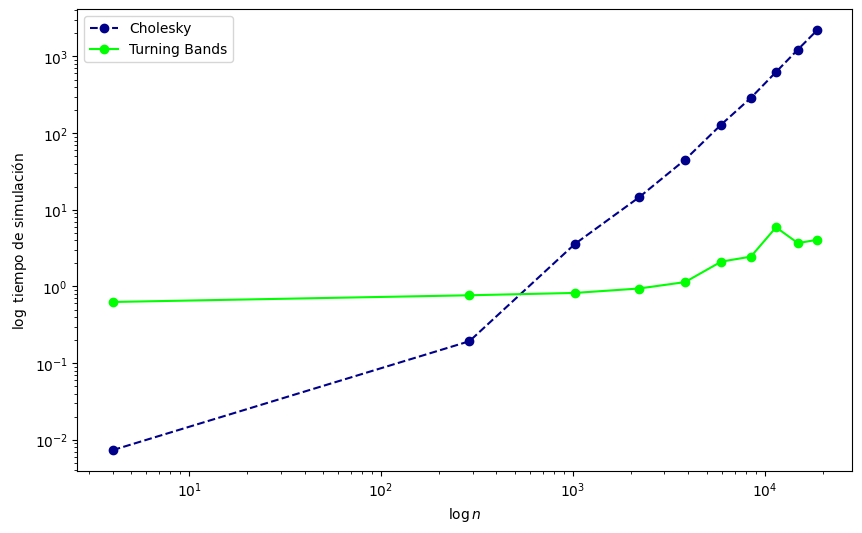

In [17]:
plt.figure(figsize= (10,6))

plt.loglog(np.array(sqrtns)**2, times_chol, 'o--', c='darkblue', label="Cholesky")
plt.loglog(np.array(sqrtns)**2, times_tb, 'o-', c='lime', label="Turning Bands")
plt.legend()
plt.xlabel(r"$\log n$")
plt.ylabel(r"$\log$ tiempo de simulación")
plt.show()